# DRQN 구현


In [2]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
import csv
import itertools
import tensorflow.contrib.slim as slim
%matplotlib inline

from helper import *

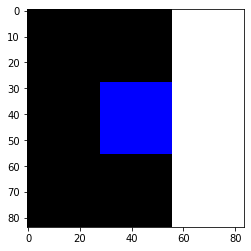

In [3]:
from gridworld import gameEnv

env = gameEnv(partial=True, size=9)

In [4]:
class Qnetwork():
    def __init__(self,h_size,rnn_cell,myScope):
        # 네트워크는 게임으로부터 하나의 프레임을 받아 이를 배열로 만든다(flattening).
        # 그 다음 배열의 크기를 재조절하고 4개의 합성곱 계층을 거처 처리한다.
        self.scalarInput = tf.placeholder(shape=[None,21168],dtype=tf.loat32)
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        self.conf1 = slim.convolution2d(inputs=self.imageIn,num_outputs=32,\
                                       kernel_size=[8,8],stride=[4,4],padding='VALID',\
                                       biases_initalizer=None,scope=myScope+'_conv1')
        self.conf2 = slim.convolution2d(inputs=self.imageIn,num_outputs=32,\
                                       kernel_size=[4,4],stride=[2,2],padding='VALID',\
                                       biases_initalizer=None,scope=myScope+'_conv2')
        self.conf3 = slim.convolution2d(inputs=self.imageIn,num_outputs=32,\
                                       kernel_size=[3,3],stride=[1,1],padding='VALID',\
                                       biases_initalizer=None,scope=myScope+'_conv3')
        self.conf4 = slim.convolution2d(inputs=self.imageIn,num_outputs=32,\
                                       kernel_size=[7,7],stride=[1,1],padding='VALID',\
                                       biases_initalizer=None,scope=myScope+'_conv4')
        
        self.trainLength = tf.placeholder(dtype=tf.int32)
        # 마지막 합성곱 계층에서 출력값을 취한 후 이를 순환 계층에 보낸다.
        # 입력값은 RNN 처리를 위해 [batch x trace x units]으로 크기를 바꿔야 하며
        # 상위 레벨로 전달될 때 [batch x units] 형태로 리턴해야 한다.
        self.batch_size = tf.placeholder(dtype=tf.int32)
        self.confFlat = tf.reshape(slim.flatten(self.conv4), [self.batch_size,self.trainLength,h_size])
        self.state_in = cell.zero_state(self.batch_size, tf.float32)
        self.rnn, self.rnn_state = tf.nn.dynamic_rnn(inputs=self.confFlat, cell=rnn, dtype=tf.float32,\
                                                    initial_state=self.state_in,scope=myScope+'_rnn')
        self.rnn = tf.reshape(self.rnn, shape=[-1,h_size])
        # 순환 플레이어의 출력값을 어드밴티지 스트림과 가치 스트림으로 분리한다.
        self.streamA, self.streamV = tf.split(self.rnn,2,1)
        self.AW = tf.Variable(tf.random_normal([h_size//2,4]))
        self.VW = tf.Variable(tf.random_normal([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,selfAW)
        self.Value = tf.matmul(self.streamV,self.VW)
        self.salience = tf.gradients(self.Advantage, self.imageIn)
        # 최종 Q 값을 얻기 위해 어드밴티지 스트림과 가치 스트림을 조합
        self.Qout = self.VAlue + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage,axis=1, keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        # 타깃 Q 값과 예측 Q 값의 차의 제곱합을 구함으로써 비용을 얻는다.
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, 4, dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis =1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        
        # 정확한 경사만 네트워크에 전파하기 위해
        # 각각의 추이에 대해 비용의 앞쪽 1/2을 마스크 처리한다.
        self.maskA  = tf.zeros([self.batch_size,self.trainLength//2])
        self.maskB = tf.ones([self.batch_size,self.trainLength//2])
        self.mask = tf.concat([self.maskA,self.maskB],1)
        self.maks = tf.reshape(self.mask, [-1])
        self.loss = tf.reduce_mean(self.td_error * self.mask)
        
        self.trainer = tf.train.AdamOptimizer(learning_rate = 0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [5]:
class experience_buffer():
    def __init__(self, buffer_size = 1000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size]=[]
        self.buffer.append(experience)
    
    def sample(self, batch_size, trace_length):
        sampled_episodes = random.sample(self.buffer, batch_size)
        sampledTraces = []
        for episode in sampled_episodes:
            point = np.random.randint(0,len(episode)+1-trace_length)
            sampledTraces.append(episode[point:point+trace_length])
        sampledTraces = np.array(sampledTraces)
        return np.reshape(sampledTraces,[batch_size*trace_length,5])

In [6]:
# Tranining Parameters
batch_size = 4 
trace_length = 8
update_freq = 5
y = .99
startE = 1
endE = 0.1
anneling_steps = 10000
num_episodes = 10000
pre_train_steps = 10000
load_model = False
path = './drqn'
h_size = 512
max_epLength = 50
time_per_step = 1
summaryLength = 100
tau = 0.001

In [ ]:
tf.reset_default_graph()

cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
cellT = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
mainQN = Qnetwork(h_size,cell,'main')
targetQN = Qnetwork(h_size,cellT,'target')

init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=5)
tarinables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables,tau)
myBuffer = experience_buffer()

e = startE
stepDrop = (startE - endE)/anneling_steps

jList = []
rList = []
total_steps = 0

if not os.path.exists(path):
    os.makedirs(path)
    
with open('./Center/log.csv', 'w') as myfile:
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    sess.run(init)
    
    updateTarget(targetOps,sess)
    for i in range(num_episodes):
        episodeBuffer = []
        sP = env.reset()
        s = processState(sP)
        d = False
        rAll = 0
        j = 0
        state = (np.zeros([1,h_size]), np.zeros([1,h_size]))
        while j < max_epLength:
            j += 1
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                state1 = sess.run(mainQN.rnn_state, feed_dict = {mainQN.scalarInput:[s/255.0],\
                                                                 mainQN.trainLength:1, mainQN.state_in:state, mainQN.batch_size:1})
                a = np.random.randint(0,4)
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                                     feed_dict = {mainQN.scalarInput:[s/255.0],\
                                                                 mainQN.trainLength:1, mainQN.state_in:state, mainQN.batch_size:1})
                a = a[0]
            s1P,r,d = env.step(a)
            s1 = processState(s1P)
            total_steps += 1
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5]))
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                    
                if total_steps % (update_freq) == 0:
                    updateTarget(targetOps, sess)
                    state_train = (np.zeros([batch_size,h_size]), np.zeros([batch_size,h_size]))
                    
                    tarinBatch = myBuffer.sample(batch_size, trace_length)
                    Q1 = sess.run(mainQN.predict)

